# Measure Clinker hydrate fringe
This is a script to measure the hydrate fringe around a clinker grain.

## loading required libaries

In [1]:
from functions import *

load_example = True
home_dir = os.path.abspath("")

## load file
select the specimen and age to be analysed in this notebook

In [2]:
specimen = 'C3S' # or C2S
age      = 7 # in days. Open "known_datasets.json to see, which images are available.

f = load_known_file( specimen, age, image_id = 0 ) # for some specimen ages, there are multiple datasets available

Select the relevant data from the dictionary and basic settings.

These data may be overwritten manually. Just define the tiff-image to be processed, select the thresholds which separate pores from hydrate (`t_pores`) and hydrate from unhydrated clinker (`t_clinker`) and define the lower limit for the rim-width (`min_rim`). The age is relevant for the final evaluation notebook (`final_evaluation.ipynb`).

Loaded an image with 2929x2929 px
 - scaling: 0.0809 µm / px
 - size:    237.1 x 237.1 µm = 0.06 mm²

 - Selected color thresholds: 0-103 for pores 104-184 for hydrates and 185-255 for alite
 - Analyzing gains with areas from 0.066 µm² up to 176.71 µm²
 - Analyzing gains with diameters from 0.30 µm up to 15.0 µm

metadata saved to D:\GIT\measure_hydrate_layer\last_processed_C3S.meta


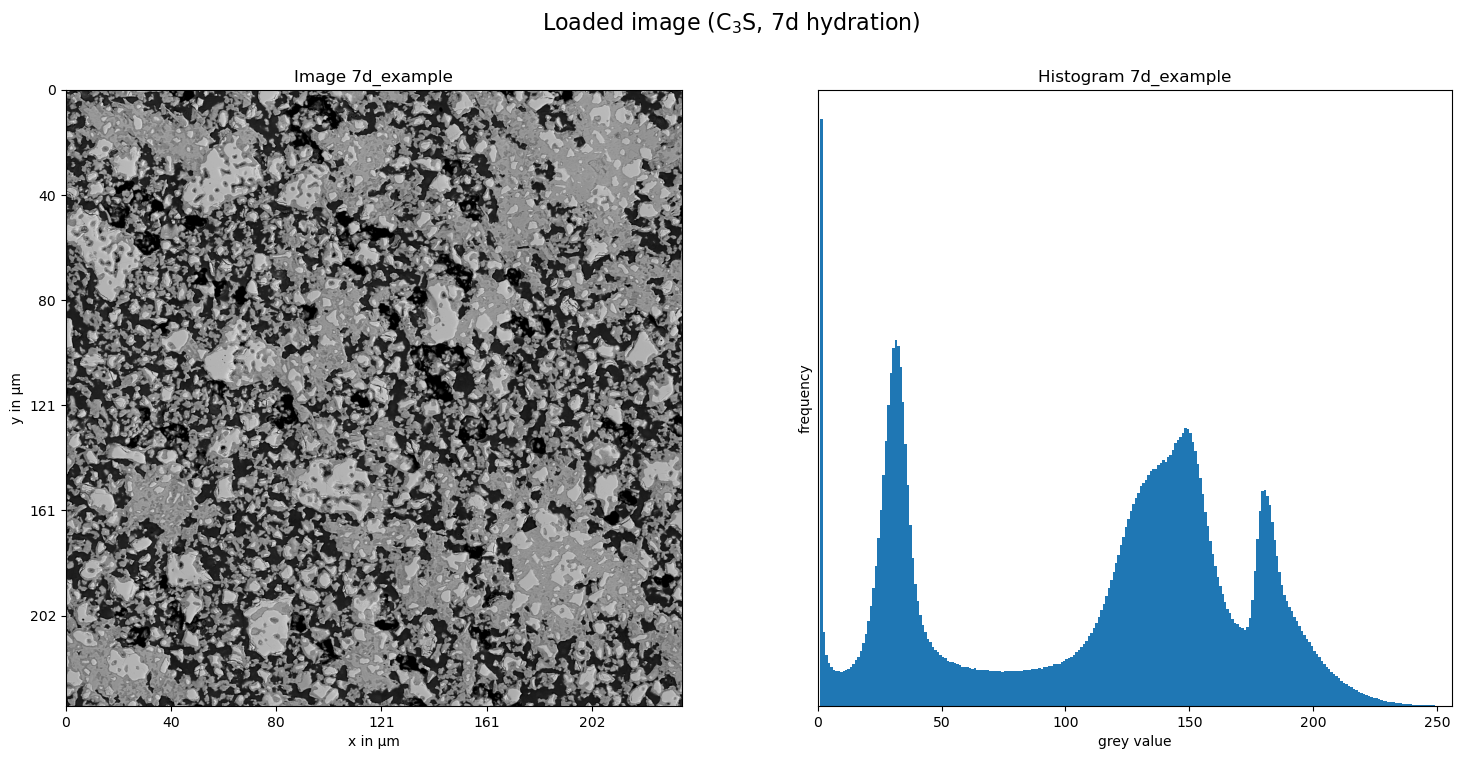

In [3]:
show_images = True
settings = {
    'specimen'        : specimen,
    'age'             : age, # in days
    'label'           : f['label'],
    't_pores'         : f['t_pores'],
    't_clinker'       : f['t_clinker'],
    'enhance_hist'    : True,
    'denoise'         : True,
    'denoising_algorithm' : 'nlm',
    'min_grain_dia'   : 0.30,  # diameter in µm
    'max_grain_dia'   : 15.00, # diameter in µm
    'min_circularity' : 0.10,  # 0.0-1.0, where 1.0 is a perfect circle
    'max_rim'         : 9.0,
    'min_rim'         : f['min_rim'],
    'reduce'          : True
}
IP = Image_Processor( f['file_path'], settings, show_images = show_images )

Loading pre-filtered image


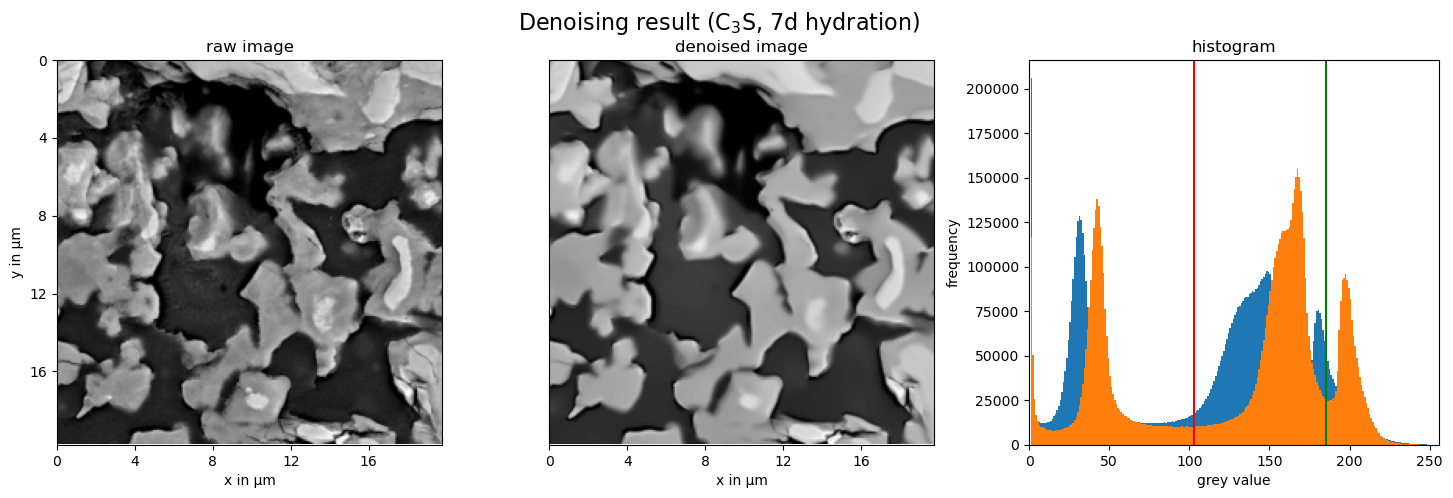

In [4]:
# enhance contrast and or denoise
IP.filter_image()

  5% done
 10% done
 15% done
 20% done
 25% done
 30% done
 35% done
 40% done
 45% done
 50% done
 55% done
 60% done
 65% done
 70% done
 75% done
 80% done
 85% done
 90% done
 95% done
100% done
fill holes took 11 s
pores: 32.3%, hydrates: 50.4%, C$_{3}}$S, 7d hydration: 17.4%


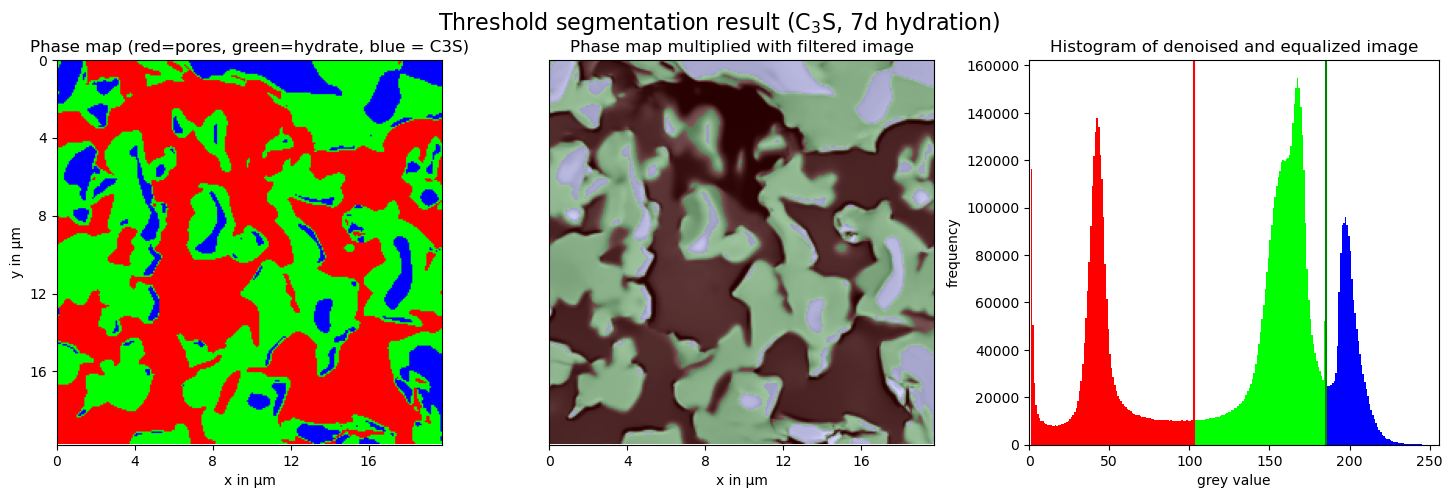

In [5]:
IP.set_thresholds( )
if show_images: IP.plot_thresh_result( )

In [6]:
IP.filter_contours(verbose = False)

  5% done
 10% done
 15% done
 20% done
 25% done
 30% done
 35% done
 40% done
 45% done
 50% done
 55% done
 60% done
 65% done
 70% done
 75% done
 80% done
 85% done
 90% done
 95% done
100% done


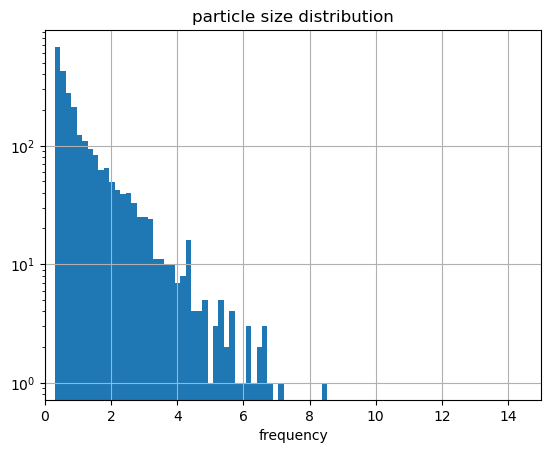

In [7]:
if show_images:
    #IP.plot_selected_contours( )

    ax = IP.df_particles['diameter'].hist(bins=50)
    ax.set_title("particle size distribution")
    ax.set_xlabel("diameter in {}".format(IP.unit))
    ax.set_xlabel("frequency".format(IP.unit))
    ax.set_xlim([0,IP.settings['max_grain_dia']])
    ax.set_yscale('log')
    plt.show()

In [8]:
IP.process_particles(multithreading=True, processCount=9, load_saved=True)

loading existing dataset.
loaded 486205 measurements


a * e^(-0.5 * ((log(x-d)-b)/c)^2)
a = 0.974,
b = -1.312,
c = 1.082,
d = 0.462


d:\GIT\measure_hydrate_layer\functions.py:399: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax[1,0].pcolormesh(Y, X, Z, vmin=0, vmax=1.0, cmap='ocean_r')


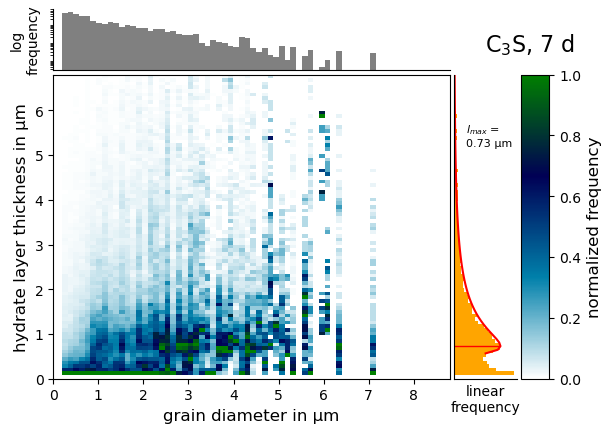

In [9]:
est_minima = 0.5 # estimated first minima for curve fitting
max_dia = 9#settings['max_grain_dia']
max_dia_rim = 7#settings['max_rim']
df_particles = IP.df_particles[(IP.df_particles.circularity > 0.3)]
r_max = plot_2d_result(df_particles, IP.df_hydrate_fringes, specimen, f['label_short'], age, IP.scaling['x'], IP.unit, est_minima, width_f = 1/8, smooting_f = 1, max_dia = max_dia, max_dia_rim = max_dia_rim)

In [10]:
df = IP.df_hydrate_fringes[ ( IP.df_hydrate_fringes.len < IP.max_rim ) ]
df = pd.merge(df, IP.df_particles[['area', 'diameter', 'perimeter', 'circularity', 'measure_percent']], left_on='particle', right_index=True)
df = df.loc[( df.circularity > 0.3 )]
df_k = pd.unique(df.particle)

img_alite_used_contours    = np.zeros((IP.w,IP.h,3), np.uint8)
img_alite_removed_contours = np.zeros((IP.w,IP.h,3), np.uint8)
for i in range(len(IP.selected_contours)):
	if i in df_k:
		cv2.drawContours(img_alite_used_contours,    [IP.selected_contours[i][0]], 0, (150,150,255), cv2.FILLED, cv2.LINE_8)
	else:
		cv2.drawContours(img_alite_removed_contours, [IP.selected_contours[i][0]], 0, (255,150,150), cv2.FILLED, cv2.LINE_8)

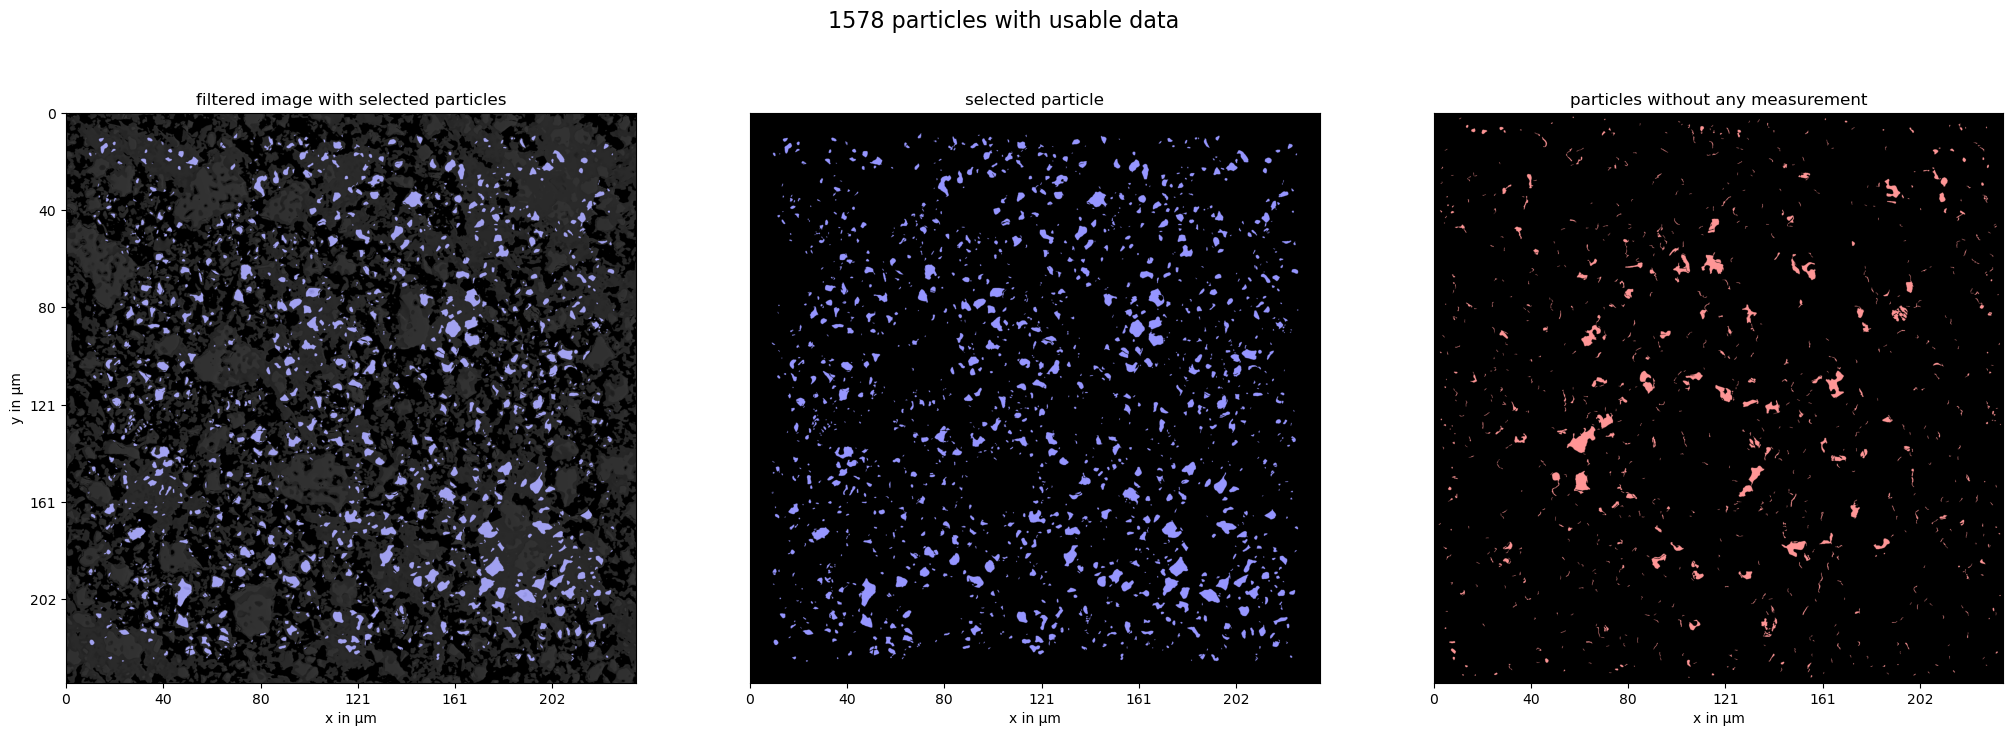

In [11]:
fig, ax = plt.subplots(1, 3, figsize=( 25, 8 ))
fig.suptitle( "{} particles with usable data".format(len(df_k), len(IP.selected_contours)), fontsize=16 )

i = 0
ax[i].imshow( cv2.addWeighted( cv2.cvtColor(IP.removed_pores, cv2.COLOR_GRAY2RGB), 0.25, img_alite_used_contours, 0.75, 0.0) )
ax[i].set_title(  "filtered image with selected particles" )
ax[i].set_xlabel( "x in {}".format( IP.unit ) )
ax[i].set_ylabel( "y in {}".format( IP.unit ) )
tick_pos, tick_labels = IP.get_image_axis_labels( ax[i] )
ax[i].set_xticks(tick_pos, tick_labels )
ax[i].set_yticks(tick_pos, tick_labels )
ax[i].set_xlim([0,IP.h-1])
ax[i].set_ylim([IP.w-1,0])

i += 1
ax[i].imshow( img_alite_used_contours )
ax[i].set_title(  "selected particle" )
ax[i].set_xlabel( "x in {}".format( IP.unit ) )
#ax[i].set_ylabel( "y in {}".format( IP.unit ) )
ax[i].set_xticks(tick_pos, tick_labels )
ax[i].set_yticks( [], [] )
ax[i].set_xlim([0,IP.h-1])
ax[i].set_ylim([IP.w-1,0])

i += 1
ax[i].imshow( img_alite_removed_contours )
ax[i].set_title(  "particles without any measurement" )
ax[i].set_xlabel( "x in {}".format( IP.unit ) )
#ax[i].set_ylabel( "y in {}".format( IP.unit ) )
ax[i].set_xticks(tick_pos, tick_labels )
ax[i].set_yticks( [], [] )
ax[i].set_xlim([0,IP.h-1])
ax[i].set_ylim([IP.w-1,0])

plt.show()